
<img src="https://github.com/Andresptrenard/01MIAR_OCT_24/blob/main/img/viu_logo.png?raw=1" width="200">

## 01MIAR - Generadores de Datos

![logo](https://github.com/Andresptrenard/01MIAR_OCT_24/blob/main/img/python_logo.png?raw=1)

*Ivan Fuertes / Andrés Pérez*

## Generadores en Python
- Yield
- Iterador Lazy

In [2]:
# Devuelve lista
def squares(n):
    result = []
    for i in range(n):
        result.append(i ** 2)
    return result

In [3]:
lista = squares(5)
print(type(lista))
print(lista)
for i in lista:
    print(f"{i}")

<class 'list'>
[0, 1, 4, 9, 16]
0
1
4
9
16


In [4]:
# Usar generador
def squares(n):
    for i in range(n):
        yield i ** 2

In [5]:
gen = squares(5)
print(type(gen))
print(gen)
for i in gen:
    print(f"{i}")

<class 'generator'>
<generator object squares at 0x7bdbec452c70>
0
1
4
9
16


- Next (envia None al generador)

In [6]:
# Usar generador
def squares(n):
    for i in range(n):
        yield i ** 2

In [7]:
x = squares(5)
print(type(x))

<class 'generator'>


In [13]:
next(x)

StopIteration: 

- Send (se pueden enviar valores en cada iteración)

In [14]:
# Generator recibe datos
def gen():
    for i in range(10):
        x = yield i
        print(f"{x} inside function")

In [27]:
g = gen()
print(type(g))

<class 'generator'>


In [28]:
next(g)

0

In [31]:
g.send(12)

12 inside function


3

## Expresiones Generadoras
- Comprehension List

In [32]:
# Comprehension List
squares_cl = [num ** 2 for num in range(5)]
print(squares_cl)
print(type(squares_cl))

[0, 1, 4, 9, 16]
<class 'list'>


- Generator Expressions

In [40]:
# Cambia [] por ()
squares_ge = (num ** 2 for num in range(5))
print(squares_ge)

<generator object <genexpr> at 0x7bdbec6a53f0>


In [41]:
next(squares_ge)

0

## Pipelines de Datos con Generadores

- Pipeline -> Generadores encadenados

- A partir de un fichero csv
  - Leer una línea
  - Dividir cada línea en una lista de valores
  - Extraer nombres de las columnas
  - Usar nombres de las columnas para crear un diccionario con los datos de cada línea
  - Filtrar los datos en base a algún criterio
  - Calcular algún valor para dichos criterios

In [44]:
!git clone https://github.com/Andresptrenard/01MIAR_OCT_24.git

Cloning into '01MIAR_OCT_24'...
remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 240 (delta 24), reused 0 (delta 0), pack-reused 190 (from 1)
Receiving objects: 100% (240/240), 70.03 MiB | 34.76 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [45]:
from os import path
file_name = path.join("01MIAR_OCT_24/res", "titanic.csv")

In [46]:
# GenExpr 01 -> Leer linea del fichero
lines = (line for line in open(file_name))
print(lines)

<generator object <genexpr> at 0x7bdbec6a5620>


In [47]:
# GenExpr 02 -> Dividir cada linea
list_line = (s.rstrip().split(",") for s in lines)
print(list_line)

<generator object <genexpr> at 0x7bdbec6a5690>


In [48]:
cols = next(list_line)

In [49]:
print(cols)

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [50]:
# GenExpr 03 -> Diccionario, keys=nombre columna
passengers = (dict(zip(cols, data)) for data in list_line)
print(passengers)

<generator object <genexpr> at 0x7bdbec6a5b60>


In [51]:
# GenExpr 04 -> Filtrado de datos
passenger_in_class3_survived = (int(passenger["Survived"]) for passenger in passengers if int(passenger["Pclass"]) == 3)
print(passenger_in_class3_survived)

<generator object <genexpr> at 0x7bdbec6a5380>


In [52]:
# Usa el Pipeline
passengers_in_class3_survived = sum(passenger_in_class3_survived)

In [53]:
print(passengers_in_class3_survived)

119


## Generadores para entrenar modelos

- Fichero de millones de líneas
- Mapeado lineal - y:f(x) = x

| x | y |
|---|---|
| 1 | 1 |
| 2 | 2 |
| 3 | 3 |
....

In [64]:
from os import path
lineal_map = path.join("01MIAR_OCT_24/res", "huge_lineal_map.csv")

# Numero de filas
num_rows = 5000000

In [65]:
# Crea fichero de prueba
with open(lineal_map, "w") as f:
    for i in range(num_rows):
        f.write(f"{i},{i}\n")

In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

- Función para leer el fichero en batches

In [72]:
batch_size = 250

In [73]:
# Carga Datos
def generate_arrays_from_file(path, batchsize):
    inputs = []
    targets = []
    batchcount = 0
    while True:
        with open(path) as f:
            for line in f:
                x,y = line.split(',')
                inputs.append(x)
                targets.append(y)
                batchcount += 1
                if batchcount > batchsize:
                    X = np.array(inputs, dtype='float32')
                    y = np.array(targets, dtype='float32')
                    yield (X, y)
                    inputs = []
                    targets = []
                    batchcount = 0

In [74]:
# Crea el modelo
model = Sequential()
model.add(Dense(16, input_dim=1, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

In [75]:
# Compila el modelo
model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['mean_squared_error'])

In [76]:
# Entrena el modelo
model.fit(generate_arrays_from_file(lineal_map, batch_size),
            steps_per_epoch=int(num_rows / batch_size), epochs=2)

Epoch 1/2
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - loss: 1316.8459 - mean_squared_error: 5556989.5000
Epoch 2/2
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - loss: 815.1273 - mean_squared_error: 2084912.1250


In [77]:
model.predict(np.array([13504, 2323]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


array([[13504.659],
       [ 2324.107]], dtype=float32)

## Generadores de datos de imágenes con Keras

- ImageDataGenerator

### flow_from_directory
- Alimentar el generador desde un directorio de imágenes
- Fotos de una misma categoría deben ubicarse en una carpeta con el nombre de la clase
- Tamaño de lotes
- Redimensión de imágenes

In [93]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [94]:
from os import path
images_folder = path.join("01MIAR_OCT_24/res", "images")
n_images = 23

In [95]:
# Apuntar al generador al directorio de imagenes
data_generator = ImageDataGenerator()
generator = data_generator.flow_from_directory(images_folder, batch_size=1, target_size=(300, 300))

Found 22 images belonging to 4 classes.


In [96]:
print(f"{generator.class_indices}")
indices_classes = {v: k for k, v in generator.class_indices.items()}

{'airplane': 0, 'boat': 1, 'car': 2, 'truck': 3}


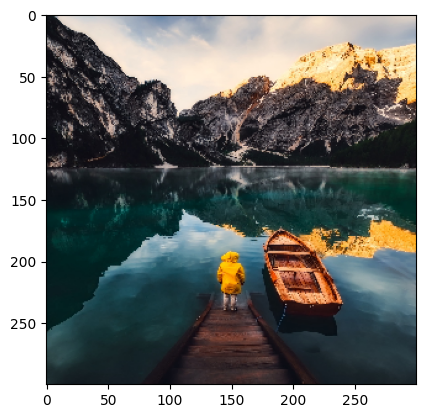

Label = boat [0. 1. 0. 0.]


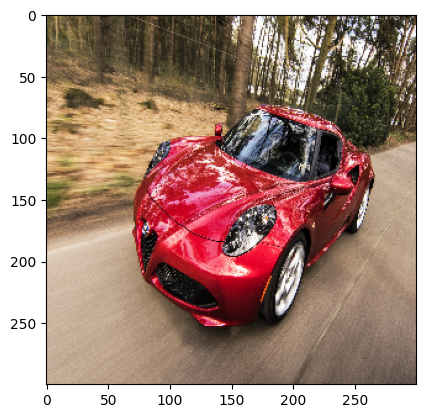

Label = car [0. 0. 1. 0.]


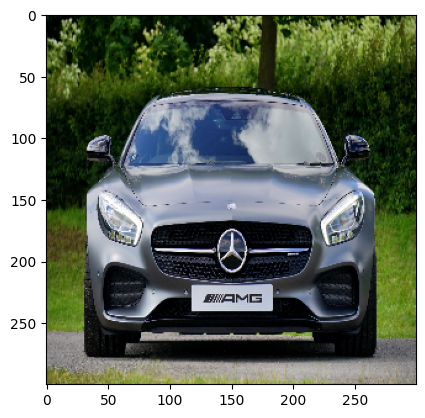

Label = car [0. 0. 1. 0.]


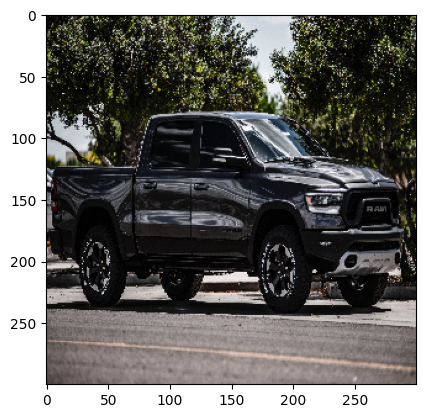

Label = truck [0. 0. 0. 1.]


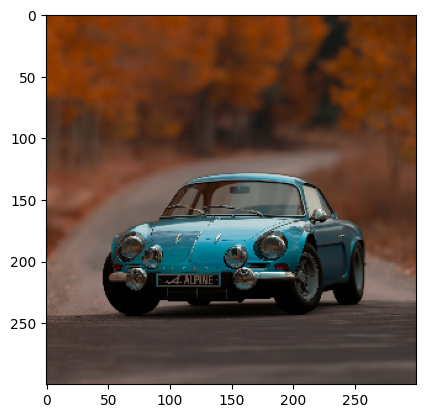

Label = car [0. 0. 1. 0.]


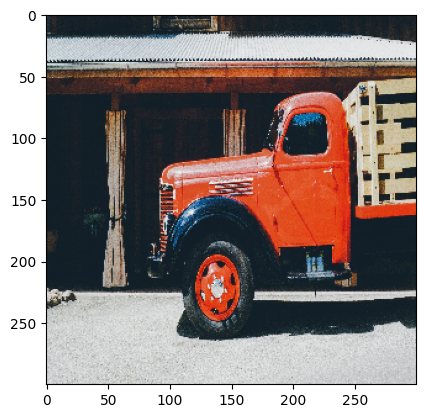

Label = truck [0. 0. 0. 1.]


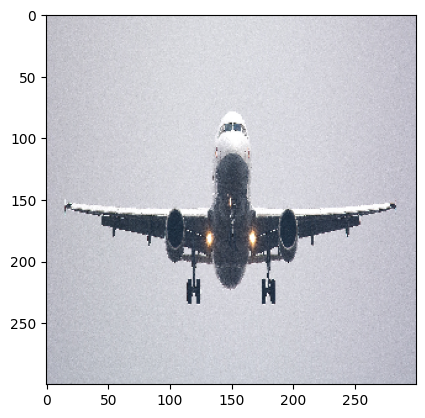

Label = airplane [1. 0. 0. 0.]


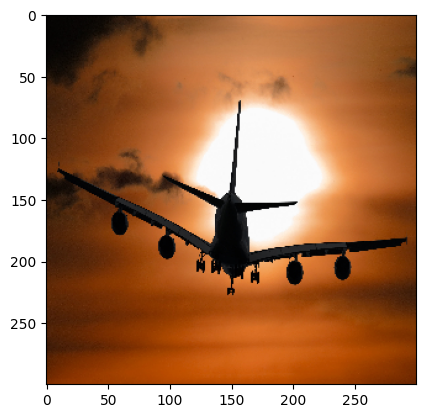

Label = airplane [1. 0. 0. 0.]


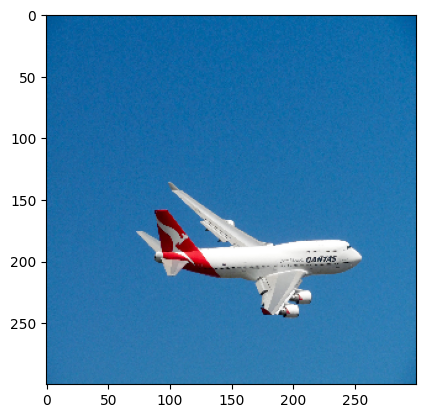

Label = airplane [1. 0. 0. 0.]


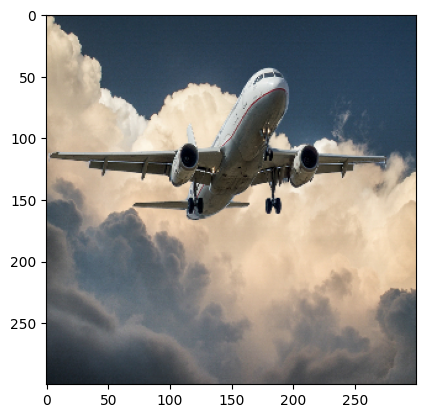

Label = airplane [1. 0. 0. 0.]


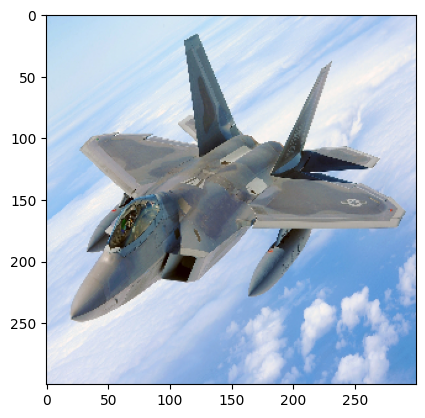

Label = airplane [1. 0. 0. 0.]


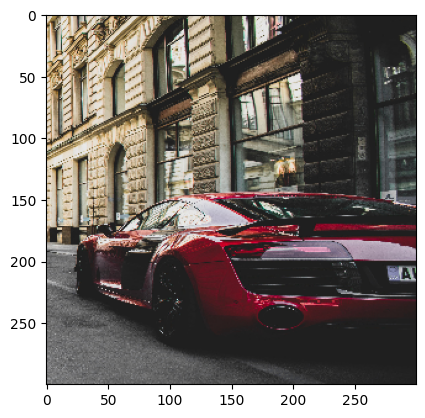

Label = car [0. 0. 1. 0.]


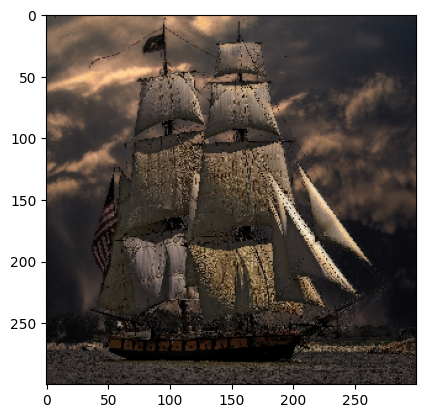

Label = boat [0. 1. 0. 0.]


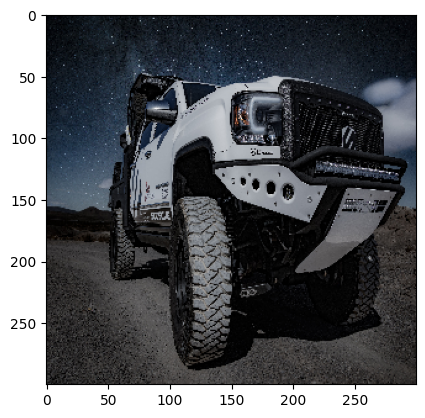

Label = truck [0. 0. 0. 1.]


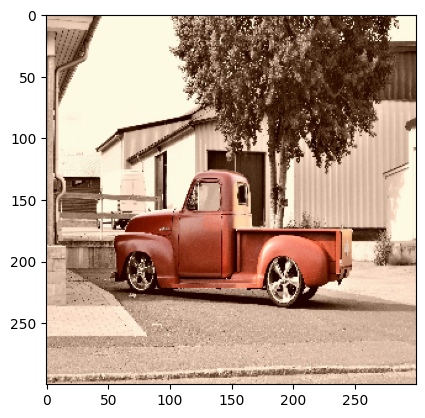

Label = truck [0. 0. 0. 1.]


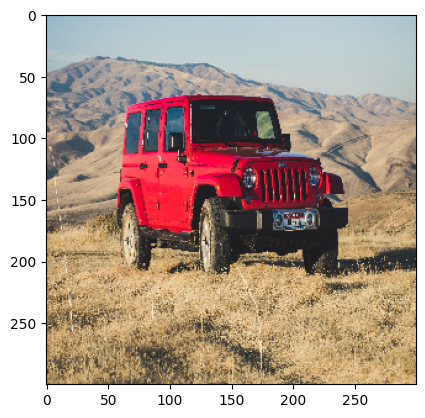

Label = truck [0. 0. 0. 1.]


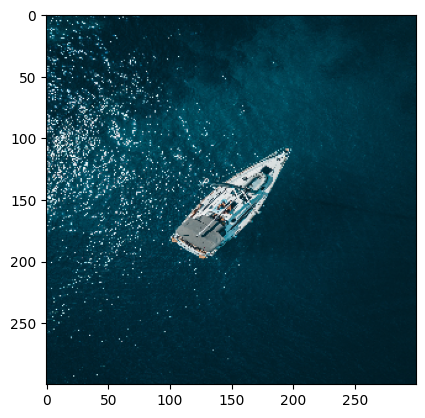

Label = boat [0. 1. 0. 0.]


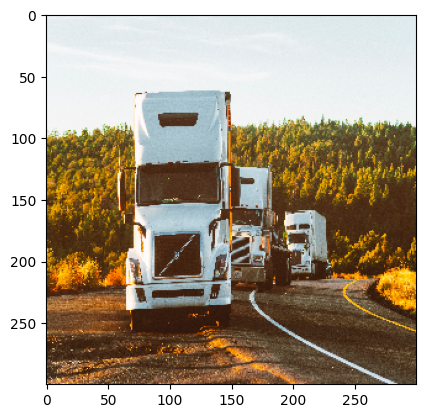

Label = truck [0. 0. 0. 1.]


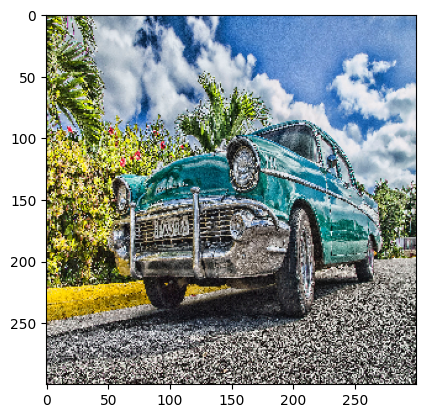

Label = car [0. 0. 1. 0.]


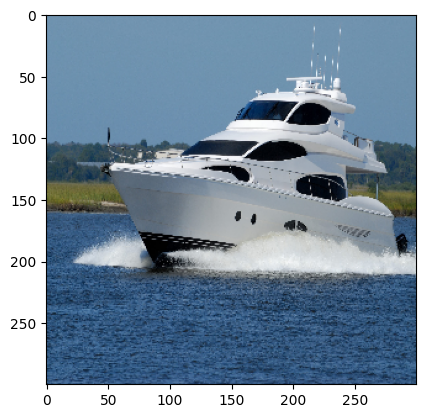

Label = boat [0. 1. 0. 0.]


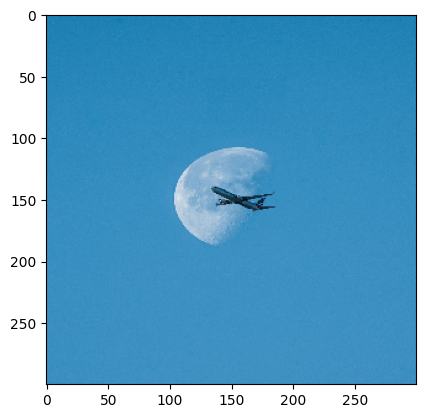

Label = airplane [1. 0. 0. 0.]


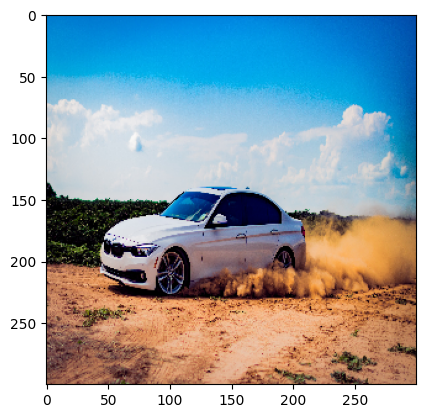

Label = car [0. 0. 1. 0.]


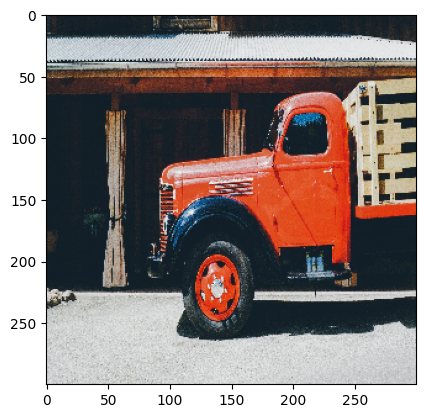

Label = truck [0. 0. 0. 1.]


In [97]:
for _ in range(n_images):
    images, labels = next(generator)
    plt.imshow((images[0].astype(int)))
    plt.show()

    print(f"Label = {indices_classes[np.argmax(labels[0])]} {labels[0]}")

- Usar generador como conjunto de datos para entrenamiento o para validación

In [98]:
#model.fit(generator, epochs = epochs, validation_data = generator_val)

NameError: name 'epochs' is not defined

### flow

- Alimentar el generador desde arrays NumPy
- MNIST https://en.wikipedia.org/wiki/MNIST_database

In [99]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [100]:
# Carga dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
x_train = np.expand_dims(x_train, axis=-1)  #to fit flow rank 4 demands (nimages, width, height, depth)
x_test = np.expand_dims(x_test, axis=-1)
print(x_train.shape)

print(type(x_train))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
(60000, 28, 28, 1)
<class 'numpy.ndarray'>


In [101]:
# Crear y compilar modelo
model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(10,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [102]:
datagen = ImageDataGenerator(rescale=1/255.,validation_split=0.2)

In [103]:
my_batch_size = 64

In [104]:
# Generadores para entrenamiento y validacion
training_generator = datagen.flow(x_train, y_train, batch_size=my_batch_size,subset='training',seed=7)
validation_generator = datagen.flow(x_train, y_train, batch_size=my_batch_size,subset='validation',seed=7)

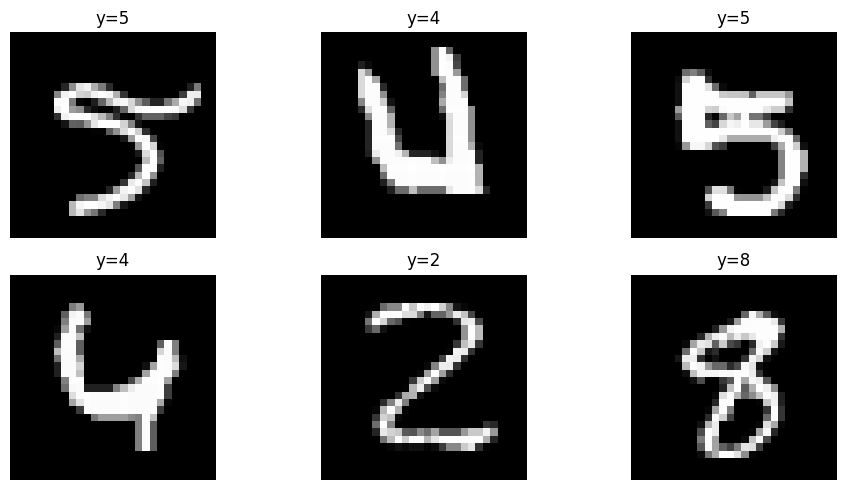

In [107]:
# Visualiza imagenes del generador
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in training_generator:
        plt.imshow((x[0]/255).reshape(28,28),cmap='gray')
        plt.title(f'y={y[0]}')
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

In [108]:
# Entrena el modelo
model.fit(training_generator, steps_per_epoch=int((len(x_train)*0.8)//my_batch_size), epochs=4,
          validation_data=validation_generator, validation_steps=int((len(x_train)*0.2)//my_batch_size))

Epoch 1/4
  2/750 ━━━━━━━━━━━━━━━━━━━━ 52s 70ms/step - accuracy: 0.1992 - loss: 2.2857

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


750/750 ━━━━━━━━━━━━━━━━━━━━ 61s 80ms/step - accuracy: 0.8977 - loss: 0.3369 - val_accuracy: 0.9794 - val_loss: 0.0652
Epoch 2/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 53us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0146
Epoch 3/4
  2/750 ━━━━━━━━━━━━━━━━━━━━ 47s 63ms/step - accuracy: 0.9844 - loss: 0.0260 

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


750/750 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.9834 - loss: 0.0498 - val_accuracy: 0.9865 - val_loss: 0.0495
Epoch 4/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9688 - val_loss: 0.0764


In [109]:
# Verificar precision del entrenamiento
score = model.evaluate(x_test, y_test, verbose=0)
print(f"Accuracy={score[1]}")

Accuracy=0.9846000075340271


### Augmentations
- Transformaciones, variaciones de imágenes
- Data Augmentation
- https://www.pexels.com/photo/brown-animal-1454786/

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
import tensorflow.keras

In [114]:
from os import path
meerkat_path = path.join("01MIAR_OCT_24/res", "meerkat.jpg")

In [115]:
# Carga la imagen, convierte a ndarray y expande las dimensiones
img = load_img(meerkat_path)
img = img_to_array(img)

print(img.shape)
img = np.expand_dims(img, axis=0)
print(img.shape)

(750, 500, 3)
(1, 750, 500, 3)


In [116]:
# Visualizar muestras de augmentations
def show_augmentations(generator):
    plt.figure(figsize=(5,5))
    for i in range(6):
        plt.subplot(2,3,i+1)
        for x in generator:
            plt.imshow(x[0]/255.)
            plt.xticks([])
            plt.yticks([])
            break
    plt.tight_layout()
    plt.show()

| Método | Descripción | Valor Muestra |
|--------|-------------|---------------|
| rotation_range | Rotación | 45 |
| width_shift_range | Desplazamiento horizontal | 0.3 |
| height_shift_range | Desplazamiento vertical | 0.3 |
| brightness_range | Rango de brillo | [0.1, 0.9] |
| rescale | Normaliza valores de pixels a un rango | 1/255. |
| shear_range | Shear | 45 |
| zoom_range | Zoom | 0.5 |
| channel_shift_range | Canales | 100 |
| horizontal_flip | Espejo en horizontal | True |
| vertical_flip | Espejo en vertical | True |
| preprocessing_function | Aplica función | f() |

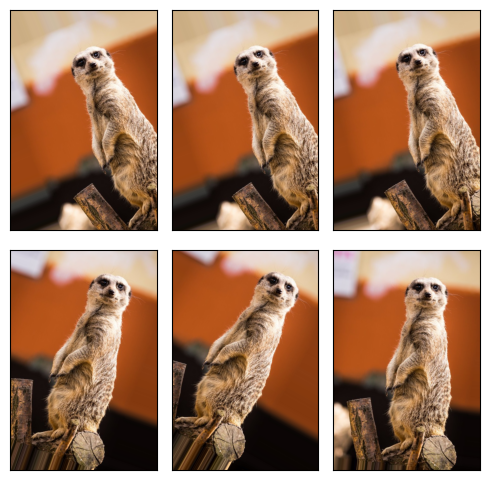

In [117]:
# Crear un generador con el metodo de augmentation
image_gen = ImageDataGenerator(rotation_range = 45)                   # rotation
# image_gen = ImageDataGenerator(height_shift_range = 0.2)               # desplazamiento horizontal
# image_gen = ImageDataGenerator(brightness_range = [0.1, 0.9])         # brillo
# image_gen = ImageDataGenerator(rescale = 1/255.)                      # normaliza valores de pixel (0,255) a (0,1)
# image_gen = ImageDataGenerator(shear_range = 40)                      # shear
# image_gen = ImageDataGenerator(zoom_range = 0.5)                      # zoom
# image_gen = ImageDataGenerator(channel_shift_range = 255)             # canales de color
# image_gen = ImageDataGenerator(vertical_flip = True)                  # flip
# image_gen = ImageDataGenerator(preprocessing_function = blur)         # custom function

generator = image_gen.flow(img, batch_size=1)

show_augmentations(generator)

In [118]:
import cv2

def blur(img):
    return (cv2.blur(img,(16,16)))

## Generadores de datos custom con Keras

- A medida
- Sequence, clase base
https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence

In [119]:
from tensorflow.keras.models import Sequential
import tensorflow as tf

In [120]:
# Clase debe sobreescribir algunos metodos
class CustomDataGenerator(tf.keras.utils.Sequence):

    # Inicializacion
    def __init__(self, data, batch_size, *args, **kwargs):
        self.data = data
        self.batch_size = batch_size
        pass

    # Devuelve el numero de batches
    def __len__(self):
        return total_data / self.batch_size

    # Devuelve un batch de datos
    def __getitem__(self, index):
        return X, y

    # Metodo opcional para ejecutar algo al final de cada epoch, (mezclar datos)
    def on_epoch_end(self):
        pass

In [123]:
class CustomDataGenerator(tf.keras.utils.Sequence):

    # Inicializacion
    def __init__(self, data, x_col, y_col=None, batch_size=32, num_classes=None, shuffle=True):
        self.batch_size = batch_size
        self.data = data
        self.indices = self.data.index.tolist()
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.x_col = x_col
        self.y_col = y_col
        self.on_epoch_end()

    # Devuelve el numero de batches
    def __len__(self):
        return len(self.indices) // self.batch_size

    # Devuelve un batch de datos
    def __getitem__(self, index):
        # Genera indices del batch
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        # Encuentra la lista de ID's
        batch = [self.indices[k] for k in index]

        # Genera los datos
        X, y = self.__get_data(batch)
        return X, y

    # Metodo opcional para ejecutar algo al final de cada epoch, (mezclar datos)
    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    # Metodo privado para la generacion de datos
    def __get_data(self, batch):
        X = []  # logica para cargar los datos de ficheros
        y = []  # logica para las variables target

        # Generar los datos
        for i, id in enumerate(batch):
            # Guardar un sample
            X[i,] = # logica para generar un sample (preprocesar/aumentar)
            y[i] = # etiquetas

        return X, y

SyntaxError: invalid syntax (<ipython-input-123-67c1667c03dd>, line 43)

In [ ]:
# Usar un custom data set generator
train_generator = CustomDataGenerator(dataframe, batch_size = 32, num_classes = 2, shuffle = True)
validation_generator = CustomDataGenerator(dataframe, batch_size = 32, num_classes = 2, shuffle = True)

model.fit(train_generator, epochs, validation_data=validation_generator)